#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.integrate import odeint
import torch
import random

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [5]:
mp = 96 #  (submerged) [kg/m]

In [6]:
# q0=[i for i in range(12)]
max_t = 1 # 10 #600  
dt = 0.5
t=np.arange(0,max_t,dt)
ds = 0.025
print(t)

[0.  0.5]


In [7]:
node_N=5

In [8]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [9]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [10]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [11]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [12]:
DT=np.diag(diag_DT) # (35) in [2]

In [13]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [14]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [15]:
CT=np.diag(diag_CT)

In [16]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [17]:
from sympy import *

In [18]:
rng = np.random.default_rng()

In [19]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [20]:
def C1(dx,dy,dz):
    return np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])

In [21]:
C1(dx,dy,dz)

array([[ 1.38808166,  3.33144311,  0.21193886,  0.19621323,  0.01248244],
       [ 2.42845955,  0.54658866,  0.43046651,  0.10584845,  1.61500612],
       [-1.06613396,  0.97562832, -1.41819832,  0.13002513, -0.87515855]])

In [22]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [23]:
def fD(dx,dy,dz,DT):
#     print(dx)
#     print(C1(dx,dy,dz).shape)
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz))

In [24]:
fD(dx,dy,dz,DT)

array([[ 812.05379544, 1948.95668624,  123.98820541,  114.78841856,
           7.30246113],
       [1420.69436851,  319.7646135 ,  251.83097707,   61.92332567,
         944.80886027],
       [-623.708357  ,  570.76086238, -829.67260995,   76.06714052,
        -511.98415918]])

In [25]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [26]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [27]:
I=np.identity(3)

In [28]:
np.dot(I,fD(dx,dy,dz,DT))

array([[ 812.05379544, 1948.95668624,  123.98820541,  114.78841856,
           7.30246113],
       [1420.69436851,  319.7646135 ,  251.83097707,   61.92332567,
         944.80886027],
       [-623.708357  ,  570.76086238, -829.67260995,   76.06714052,
        -511.98415918]])

In [29]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [30]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [31]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [32]:
DR=np.diag(diag_DR) 

In [33]:
dI= 0.69# Inner diameter of pipe, [m]

In [34]:
A=math.pi*((d0/2)**2-(dI/2)**2)

In [35]:
A

0.08091250419136858

In [36]:
fg_e=np.array([[0,0,(mp-qw*A)*9.81] for x in range(node_N)]).reshape(3, node_N)

In [37]:
fg_e

array([[  0.        ,   0.        , 128.16454223,   0.        ,
          0.        ],
       [128.16454223,   0.        ,   0.        , 128.16454223,
          0.        ],
       [  0.        , 128.16454223,   0.        ,   0.        ,
        128.16454223]])

In [38]:
from numpy import linalg as LA

In [39]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [40]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [41]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [42]:
hi(x,y,z,d0)

array([[2.6805],
       [2.6805],
       [2.6805],
       [2.6805],
       [2.6805]])

In [43]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[6338.99811768],
       [6338.99811768],
       [6338.99811768],
       [6338.99811768],
       [6338.99811768]])

In [44]:
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1])).reshape(3,node_N)

In [45]:
sigma(x,y,z)

array([[   0.        ,    0.        , 6338.99811768,    0.        ,
           0.        ],
       [6338.99811768,    0.        ,    0.        , 6338.99811768,
           0.        ],
       [   0.        , 6338.99811768,    0.        ,    0.        ,
        6338.99811768]])

In [46]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [47]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [48]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [49]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [50]:
np.dot(Re_t(φ,θ,ψ)[0],Rb_t) 

array([[ 0.42294181, -0.16315809, -0.89134711],
       [ 0.43934557,  0.89722843,  0.04423365],
       [ 0.79252489, -0.41031766,  0.45115819]])

In [51]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [52]:
# Fossen paper, equation (12)

In [53]:
# φ,θ,ψ=1,2,3

In [54]:
def Re_b(φ,θ,ψ):
    return np.dot(Re_t(φ,θ,ψ), Rb_t ) # (5) in[3]

In [55]:
Re_b(φ,θ,ψ).shape

(5, 3, 3)

In [56]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [57]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [58]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [59]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [60]:
d_s(x,y,z,x,y,z)

array([[ 0.        , -0.96125324,  0.08945481, -0.86998414,  0.43993161],
       [ 0.        ,  0.23824438,  0.9906441 , -0.00827744, -0.74467929],
       [ 0.        , -0.13867886,  0.10306364,  0.49301022, -0.50190929]])

In [61]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [62]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [63]:
def ne(x,y,z,φ,θ,ψ):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
                         Re_t(φ,θ,ψ))
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [64]:
def ne_(x,y,z,dx,dy,dz):
#     print(fg_e)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
#     return -fg_e-fD(dx,dy,dz,DT)-sigma(x,y,z)
    return -fg_e-fD(dx,dy,dz,DT)

In [65]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [66]:
ne(x,y,z,φ,θ,ψ)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.35380671e+08,  1.13674376e+08, -6.11840332e+07],
       [ 1.34538431e+06,  8.77011271e+07,  1.61105352e+07],
       [-8.58662931e+06, -7.75222385e+06,  6.27710408e+06],
       [ 1.19461157e+08, -5.32796284e+08, -1.83073077e+08]])

In [67]:
ne_(x,y,z,dx,dy,dz)

array([[ -812.05379544, -1948.95668624,  -252.15274764,  -114.78841856,
           -7.30246113],
       [-1548.85891074,  -319.7646135 ,  -251.83097707,  -190.0878679 ,
         -944.80886027],
       [  623.708357  ,  -698.92540461,   829.67260995,   -76.06714052,
          383.81961695]])

In [68]:
Re_b(φ,θ,ψ).shape

(5, 3, 3)

In [69]:
def Irho_e(φ,θ,ψ):
    return np.multiply(np.multiply(Re_t(φ,θ,ψ),Irho),Re_t(φ,θ,ψ)) # (19) in [3] 

In [70]:
Irho_e(φ,θ,ψ)

array([[[17.88797711,  0.        ,  0.        ],
        [ 0.        , 80.50188529,  0.        ],
        [ 0.        ,  0.        , 40.70874332]],

       [[76.50228286,  0.        ,  0.        ],
        [ 0.        , 47.71334984,  0.        ],
        [ 0.        ,  0.        , 88.23844016]],

       [[ 1.50398215,  0.        ,  0.        ],
        [ 0.        ,  8.85293997,  0.        ],
        [ 0.        ,  0.        , 31.26327695]],

       [[ 0.98698688,  0.        ,  0.        ],
        [ 0.        , 93.65481426,  0.        ],
        [ 0.        ,  0.        ,  2.54643973]],

       [[27.15448384,  0.        ,  0.        ],
        [ 0.        , 71.54707944,  0.        ],
        [ 0.        ,  0.        , 72.95066336]]])

In [71]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
                  [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
                  [-np.sin(θ),0,1]])

In [72]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [73]:
Π(φ,θ,ψ).shape

(5, 3, 3)

In [74]:
def ωe(φ,θ,ψ):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
    B=np.array([φ,θ,ψ]).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [75]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [76]:
ωe(φ,θ,ψ)

array([[ 0.35468453, -1.04251611,  0.28106551],
       [-0.81957414,  0.1306718 , -0.64415126],
       [-0.94701761, -0.56520574, -0.76635904],
       [-0.84659773, -1.17864942, -0.93707496],
       [-0.84803422,  0.17655095,  1.21402159]])

In [77]:
# diag_CR = 1e11*np.array([1, 1, 1]) 
diag_CR = 1e5*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [78]:
CR

array([[100000.,      0.,      0.],
       [     0., 100000.,      0.],
       [     0.,      0., 100000.]])

In [79]:
def me(φ,θ,ψ):
    A=np.multiply(np.multiply(Re_t(φ,θ,ψ),CR),Re_t(φ,θ,ψ))
    B=ωe(φ,θ,ψ)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [80]:
me_=me(φ,θ,ψ)

In [81]:
me_

array([[   6344.58872273,  -83924.51233012,    5720.91191797],
       [ -62699.29279652,    6234.78951147,  -28419.45132093],
       [  -1424.29758559,   -5003.73248211,  -11979.44742605],
       [   -835.58085133, -110386.19249481,   -1193.10245363],
       [ -23027.93151982,   12631.70516649,   44281.84009546]])

In [82]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [83]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [84]:
ne_(x,y,z,dx,dy,dz)

array([[ -812.05379544, -1948.95668624,  -252.15274764,  -114.78841856,
           -7.30246113],
       [-1548.85891074,  -319.7646135 ,  -251.83097707,  -190.0878679 ,
         -944.80886027],
       [  623.708357  ,  -698.92540461,   829.67260995,   -76.06714052,
          383.81961695]])

In [85]:
C=ne(x,y,z,φ,θ,ψ)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [86]:
d_s(a,b,c,x,y,z)

array([[       0.        , -3595469.89862711, 10858071.79150798,
          -37859.49801276,   482847.29244416],
       [       0.        ,   555783.98026666,  -382800.90181615,
         -363855.31587441, -1979855.40914403],
       [       0.        ,  -299144.86259124,  1139188.66782004,
          -37483.71489901,  -714008.61242317]])

In [87]:
Re_b(φ,θ,ψ).shape

(5, 3, 3)

In [88]:
ne_(x,y,z,dx,dy,dz).T

array([[ -812.05379544, -1548.85891074,   623.708357  ],
       [-1948.95668624,  -319.7646135 ,  -698.92540461],
       [ -252.15274764,  -251.83097707,   829.67260995],
       [ -114.78841856,  -190.0878679 ,   -76.06714052],
       [   -7.30246113,  -944.80886027,   383.81961695]])

In [89]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ -76.29396163,  -27.56589024,   39.64984849,   37.47835439,
        -160.00548066]),
 array([-14.5622315 , -42.92618918, -35.93326552,  93.40242287,
        -39.70047405]),
 array([-1.17816877,  1.82522413,  0.46036818, -0.44295963,  0.11172484]),
 numpy.ndarray,
 array([-0.6546517 ,  0.92257981, -1.16492998,  0.31754877, -0.64572222]))

In [90]:
ne_(x,y,z,dx,dy,dz).T+np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ),ne_(x,y,z,dx,dy,dz).T)

array([[-1458.73707805, -3267.72249923,   897.05082132],
       [-3623.3113613 ,  -759.44183239, -1878.92483655],
       [-1125.7125084 ,  -188.23025944,  1049.2284843 ],
       [  -63.43799073,  -348.59556424,  -241.39842064],
       [  748.26659793, -1578.57434488,   643.61052185]])

### Catenary

In [91]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [92]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [93]:
Fx_0=82945396

In [94]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [95]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [96]:
delta_x=horizontal_length/(node_N-1)

In [97]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [98]:
x0,z0

([0.0,
  2763.171211115405,
  5526.34242223081,
  8289.513633346216,
  11052.68484446162],
 [0.0,
  43.34801072052057,
  173.43471225842703,
  390.38815474416316,
  694.4218951076863])

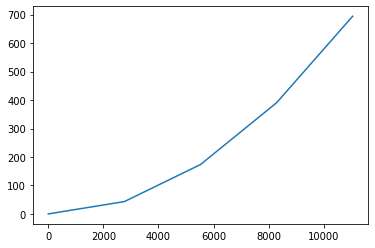

In [99]:
plt.plot(x0, z0)
plt.show()

In [100]:
# rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [101]:
j=0
k=0
for i in range(len(q0)):
    if i%12==0:
        q0[i]=x0[j]
        q0[i+4]=z0[j]
        q0[i+6]=random.uniform(0, 1)
        q0[i+8]=random.uniform(0, 1)
        q0[i+10]=random.uniform(0, 1)
        j+=1   
 
         

In [102]:
q0

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.43321154e-03, 0.00000000e+00,
       7.49154988e-01, 0.00000000e+00, 6.32031818e-01, 0.00000000e+00,
       2.76317121e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.33480107e+01, 0.00000000e+00, 5.34844390e-01, 0.00000000e+00,
       8.92188796e-01, 0.00000000e+00, 6.48330830e-01, 0.00000000e+00,
       5.52634242e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.73434712e+02, 0.00000000e+00, 6.53894725e-01, 0.00000000e+00,
       8.10485208e-01, 0.00000000e+00, 2.35167241e-01, 0.00000000e+00,
       8.28951363e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.90388155e+02, 0.00000000e+00, 4.38182803e-01, 0.00000000e+00,
       6.91660482e-01, 0.00000000e+00, 8.46543599e-01, 0.00000000e+00,
       1.10526848e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.94421895e+02, 0.00000000e+00, 8.16985645e-01, 0.00000000e+00,
      

### Vessel

In [103]:
t

array([0. , 0.5])

In [104]:
sampleTime = 0.01                 # sample time [seconds]
N = 50_000                         # number of samples

In [105]:
N

50000

In [106]:
vehicle=semisub('DPcontrol',10,10.,40.0,0,0) 

In [ ]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [ ]:
simData.shape

In [ ]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=0.01

In [ ]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [ ]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'                  # browser for visualization of animated GIF

In [ ]:
plotVehicleStates(simTime, simData, 3)

In [ ]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [ ]:
# class Time:
#     def __init__(self):
#         self.time=0

In [ ]:
# co=Time()

In [ ]:
# t

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
def grayscott1d(Q, t, simData):
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time=t
    
    
#     print(Q)   
    
    idx = find_nearest(np.array(ans_t), t)
#     ind=ans_t.index(val)
    # State vectors
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
#     phi_ve = R2D(ssa(simData[:, 3][idx]))
#     theta_ve = R2D(ssa(simData[:, 4][idx]))
#     psi_v = R2D(ssa(simData[:, 5][idx]))
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0::12],Q[2::12],Q[4::12]
#     print(x0[-1],y0[-1])

    x[-1]=x_ve+x0[-1]
    y[-1]=y_ve
    z[-1]=z_ve+z0[-1]
#     x[0]=0
#     y[0]=0
#     z[0]=0
#     print(z)
#     print(z_ve)
#     print(x,y,z)
    dx,dy,dz=Q[1::12],Q[3::12],Q[5::12]
    
    dx[-1]=u_ve
    dy[-1]=v_ve 
    dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6::12],Q[8::12],Q[10::12]
    
    φ[-1]=phi_ve
    θ[-1]=theta_ve
    ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7::12],Q[9::12],Q[11::12]
    
    dφ[-1]=p_ve
    dθ[-1]= q_ve
    dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,φ,θ,ψ)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
    ddx,ddy, ddz = (1/Ws*(d_s(a,b,c,x,y,z).T + 
                          np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T)
                         )).T
    print('ddx',ddx)  
    print('ddy',ddy) 
    print('ddz',ddz) 
    
    me_=me(φ,θ,ψ)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
    C1=np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), np.einsum('ijk,ik->ij', Irho_e(φ,θ,ψ).astype(float),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(float), np.array([dφ,dθ,dψ]).astype(float).T)))
        
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(float),np.array([dφ,dθ,dψ]).astype(float).T),
                 np.einsum('ijk,ik->ij',Irho_e(φ,θ,ψ).astype(float),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(float),np.array([dφ,dθ,dψ]).astype(float).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
    print(me_)
    print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
    C3= np.einsum('ijk,ik->ij',Re_b(φ,θ,ψ).astype(float),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(float).T)
    
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,φ,θ,ψ))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(float),np.array([dφ,dθ,dψ]).astype(float).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
    C5= np.einsum('ijk,ik->ij',Re_b(φ,θ,ψ).astype(float),-np.dot(DR,K1).astype(float).T)
    print('C1',C1)
    print('C2',C2)
    print('C3',C3)
    print('C4',C4)
    print('C5',C5)
    print()
    B =-C1-C2+C3+C4+C5
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
    A1 =Re_b(φ,θ,ψ).astype(float)
    A2 = Irho_e(φ,θ,ψ).astype(float)
    A3=Π(φ,θ,ψ).astype(float)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
    A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
    
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 


    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T 
    
#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
# #     print(ans_ψ)

#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    A1111=np.concatenate(np.stack([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0).T) 
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A)
    return A1111
    

In [ ]:
q0

In [ ]:
np.concatenate(np.stack([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])]).T)

In [ ]:
# q0=[i for i in range(12)]
max_t = 2 #0.1 # 10 #600  
dt = 0.5
t=np.arange(0,max_t,dt)
# ds = 0.025
print(t)

In [ ]:
startTime1 = datetime.now()
us=odeint(grayscott1d, q0, t, args=(simData,)
#           ,mxstep=5000
         )
print(datetime.now() - startTime1)

In [ ]:
t

In [ ]:
us[1]

In [ ]:
fig=plt.figure(figsize=(13,5))
ax = fig.gca(projection='3d') 
X0=us[0,[12*i for i in range(node_N)]]
Y0=us[0,[12*i+2 for i in range(node_N)]]
Z0=us[0,[12*i+4 for i in range(node_N)]]
X=us[2,[12*i for i in range(node_N)]]
Y=us[2,[12*i+2 for i in range(node_N)]]
Z=us[2,[12*i+4 for i in range(node_N)]]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
plot3D(us, numDataPoints, FPS, filename, 3)